In [4]:
import tensorflow as tf
import numpy as np
import os
import random
from skimage.io import imread, imshow
import skimage.transform
import matplotlib.pyplot as plt

### Prepare the Dataset

In [116]:
source_path = "S1Hand/"
label_path = "S1OtsuLabelHand/"

source = []
label = []
for file in os.listdir(source_path):
    if file.endswith("tif"):
      source.append(file)
        
for file in os.listdir(label_path):
    if file.endswith("tif"):
      label.append(file)

In [117]:
## SAnity Check
source = sorted(source)
label = sorted(label)
print(len(source))
print(len(label))

577
577


In [118]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 2


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [127]:
X = np.zeros((len(source), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(label),IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [ ]:
# Sanity Check
print(X.shape)
print(Y.shape)

In [ ]:
for count, file in enumerate(source):
    source_img = imread(source_path +'/' +file ) #[0:2,:,:]
    # print(f"the shape of the source image: {source_img.shape}")
    new_image = np.transpose(source_img, (1, 2, 0))
    X[count] = new_image


for count, file in enumerate(label):
    slabel_img = imread(label_path + '/'+file ) #[:,:,:,IMG_CHANNELS]
    y = np.expand_dims(slabel_img, axis=2)
    # print(f"The shape of y labels: {y.min()}")
    Y[count] = y 

In [125]:
# Sanity Check
print(X.shape)
print(Y.shape)

(577, 128, 128, 5)
(577, 128, 128, 2)


### Define the UNET

In [ ]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

### Train the model

In [123]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_S1Hand.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=70, monitor='val_loss'),checkpointer]

results = model.fit(x_train, y_train, validation_split=0.1, batch_size=12, epochs=200, callbacks=callbacks)

### Evaluate the model on the test data

In [110]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=12)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 0s 16ms/step - loss: 0.8661 - accuracy: 0.6650
test loss, test acc: [0.8661026358604431, 0.6650211811065674]


In [111]:
y_pred = model.predict(X)
y_pred_thresholded = y_pred >0.5

intersection = np.logical_and(Y, y_pred_thresholded)
union = np.logical_or(Y, y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print("IoU score is:", iou_score)

19/19 [==============================] - 1s 25ms/step
IoU score is: 0.688331137928985


### Classification Map

In [113]:
# Use Trainned UNET model for segmenting a test image
test_img = np.expand_dims(x_test[4], axis=0)
prediction = model.predict(test_img)
prediction = prediction >0.5

1/1 [==============================] - 0s 17ms/step


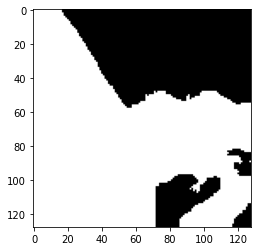

In [114]:
# View and Save segmented image
prediction_image = prediction.reshape(128,128)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('UNET_S1Hand.jpg', prediction_image, cmap='gray')

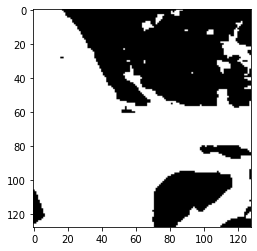

In [115]:
# The Corresponding Ground Truth Mask
plt.imshow(y_test[4].reshape(128,128), cmap='gray')